#Prepare a data

In [1]:
 !pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"petarvasiljevic","key":"dae47a988e82509cb90196d0de28fc56"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d andrewmvd/face-mask-detection

face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip face-mask-detection.zip -d face-mask-detection

Archive:  face-mask-detection.zip
replace face-mask-detection/annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

face-mask-12k-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip face-mask-12k-images-dataset.zip -d face-mask-12k-images-dataset

Archive:  face-mask-12k-images-dataset.zip
replace face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
!ls "/content/gdrive/MyDrive/Machine learning/mask detection"

haarcascade_frontalface_default.xml  mask-detection.ipynb


#Import Libraries

In [14]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19

#Face detection with Haar cascading

Import Haar Cascade

In [15]:
haarcascade_path = "/content/gdrive/MyDrive/Machine learning/mask detection/haarcascahde_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

Check if Haar Cascade is working

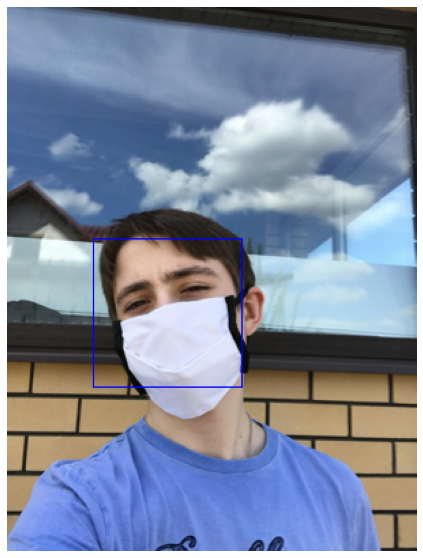

In [16]:
img = cv2.imread('face-mask-detection/images/maksssksksss60.png')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray_img, 1.1, 4) 

out_img = img
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(out_img)

Seems like it's working, but...

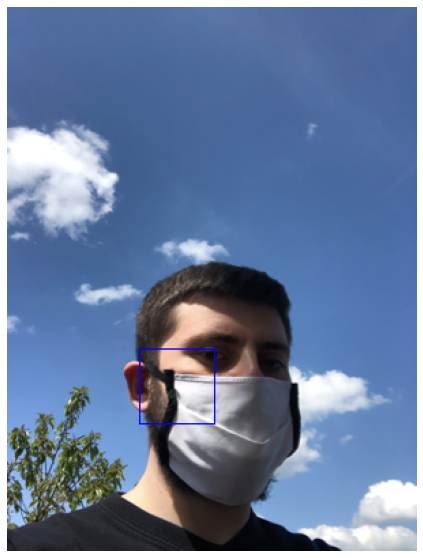

In [17]:
img = cv2.imread('face-mask-detection/images/maksssksksss500.png')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray_img, 1.1, 4) 

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(out_img)

We can see that is is not pretty accurate when person has a mask

#Transfer Learning - VGG19

In [18]:
train_path = 'face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_path = 'face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_path = 'face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [19]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   horizontal_flip = True,
                                   rotation_range = 10,
                                   zoom_range = 0.2,
                                   shear_range = 0.2)
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size = (150,150),
                                                    batch_size = 32,
                                                    class_mode='categorical')

Found 10000 images belonging to 2 classes.


In [20]:
test_datagen = ImageDataGenerator(rescale = 1.0/255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size = (150,150),
                                                  batch_size = 32,
                                                  class_mode='categorical')

Found 992 images belonging to 2 classes.


In [21]:
val_datagen = ImageDataGenerator(rescale = 1.0/255)
val_generator = val_datagen.flow_from_directory(val_path,
                                                target_size = (150,150),
                                                batch_size = 32,
                                                class_mode='categorical')

Found 800 images belonging to 2 classes.


In [38]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(150,150,3))
base_model.trainable = False

In [39]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [40]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 22,122,306
Trainable params: 2,097,922
Non-trainable params: 20,024,384
_________________________________________________________________


In [41]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
batch_size = 64
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch = len(train_generator)//batch_size,
                              epochs=20,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator)//batch_size
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
4/4 [==============================] - 2s 260ms/step - loss: 1.3929 - accuracy: 0.5125
Epoch 2/20
4/4 [==============================] - 1s 217ms/step - loss: 0.5076 - accuracy: 0.8000
Epoch 3/20
4/4 [==============================] - 1s 215ms/step - loss: 0.4021 - accuracy: 0.8344
Epoch 4/20
4/4 [==============================] - 1s 221ms/step - loss: 0.3298 - accuracy: 0.8542
Epoch 5/20
4/4 [==============================] - 1s 217ms/step - loss: 0.4608 - accuracy: 0.8135
Epoch 6/20
4/4 [==============================] - 1s 223ms/step - loss: 0.2002 - accuracy: 0.9281
Epoch 7/20
4/4 [==============================] - 1s 225ms/step - loss: 0.1866 - accuracy: 0.9313
Epoch 8/20
4/4 [==============================] - 1s 222ms/step - loss: 0.0975 - accuracy: 0.9573
Epoch 9/20
4/4 [==============================] - 1s 229ms/step - loss: 0.0595 - accuracy: 0.9719
Epoch 10/20
4/4 [==============================] - 1s 223ms/step - loss: 0.0947 - accuracy: 0.9635
Epoch 11/20
4/4 [==

Let's see how it does on test data

In [43]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.051040682941675186, 0.9858871102333069]

98% pretty good!

Let's try it on sample

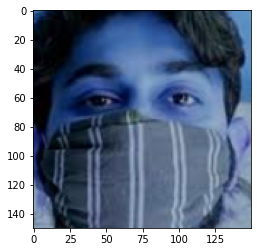

In [45]:
img_path = 'face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1175.png'
img = cv2.imread(img_path)
img = cv2.resize(img, (150,150))

plt.imshow(img)
img = np.reshape(img, [1,150,150,3])
img = img/255.0

In [46]:
model.predict(img)

array([[0.98155725, 0.05596903]], dtype=float32)

Save the model

In [47]:
model.save('model.h5')

#Test the model on real world photos

In [99]:
def evalute_on_real_world(image):

  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  out_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  faces = face_cascade.detectMultiScale(gray_img, 1.1, 4)

  for x,y,w,h in faces:
    cv2.rectangle(out_img, (x, y), (x+w, y+h), (0, 0, 255), 2)

    cropped_img = out_img[y:y+h, x:x+w]
    cropped_img = cv2.resize(cropped_img, (150, 150))
    cropped_img = np.reshape(cropped_img, [1, 150, 150, 3])/255

    prediction = model.predict(cropped_img)

    text = 'Mask' if prediction.argmax()==0 else 'No Mask'

    cv2.putText(out_img, text, (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (110, 255, 255), 2)

  plt.imshow(out_img)


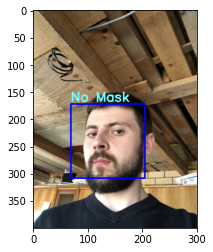

In [100]:
img = cv2.imread('face-mask-detection/images/maksssksksss624.png')
evalute_on_real_world(img)

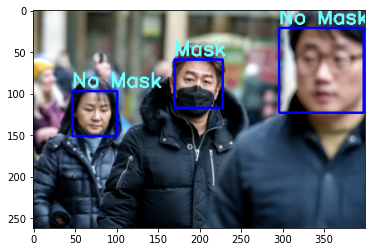

In [101]:
img = cv2.imread('face-mask-detection/images/maksssksksss244.png')
evalute_on_real_world(img)

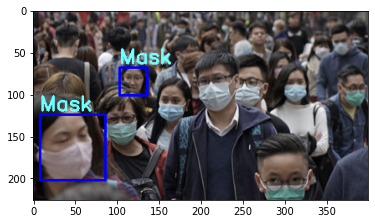

In [102]:
img = cv2.imread('face-mask-detection/images/maksssksksss558.png')
evalute_on_real_world(img)

For this image, we can see that Haar couldn't detect all the faces. Besides that, our model did wrong prediction for the woman in the back.
Even though our model has 98% accuracy, it isn't perfect in practice.